In [48]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt

In [49]:
CURRENT_DIR = Path.cwd()
PARENT_DIR = CURRENT_DIR.parent
AF_DATA_DIR = PARENT_DIR / "T03_af"
print(AF_DATA_DIR)

c:\Users\admin\Coding\research\weld-ml\src\P02_data\T03_af


In [50]:
# Load AF data
pickle_filepath = AF_DATA_DIR / "S17_af_extract.pkl"
with open(pickle_filepath, "rb") as handle:
    data = pickle.load(handle)
afs = data["data"]

In [51]:
afs.columns

Index(['sample_no', 'af_contact', 'af_dwell', 'af_weld'], dtype='object')

## Test converion of time index to timedelta


In [52]:
sample_no = 0
time_section = "af_weld"
_af = afs.loc[sample_no, time_section]["Fz"]

print(_af.index.values[:5])
print(
    pd.to_timedelta(_af.index.values * 1000, unit="ms")[:5]
)  # I will use this method.

[38.56 38.57 38.58 38.59 38.6 ]
TimedeltaIndex(['0 days 00:00:38.560000', '0 days 00:00:38.570000',
                '0 days 00:00:38.580000', '0 days 00:00:38.590000',
                '0 days 00:00:38.600000'],
               dtype='timedelta64[ns]', freq=None)


## Test down sampling


Original sampling frequency: 100.0 Hz
Downsampled sampling frequency: 10.0 Hz
Number of data points (original): 13001
Number of data points (downsampled): 1301


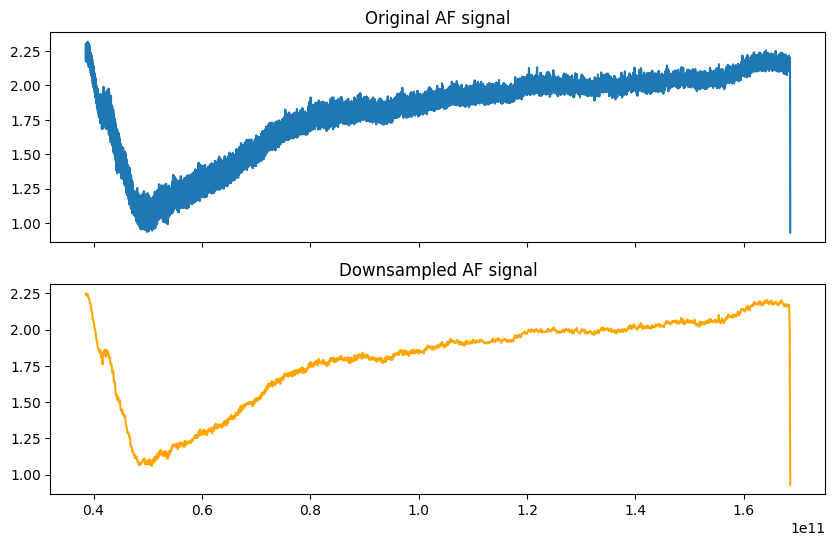

In [53]:
sample_no = 0
# time_section = "af_dwell"
time_section = "af_weld"

# Extract original AF signal
af_ori = afs.loc[sample_no, time_section]["Fz"].copy()
af_sampled = afs.loc[sample_no, time_section]["Fz"].copy()

# Convert index to TimeDeltaIndex
af_ori.index = pd.to_timedelta(af_ori.index.values * 1000, unit="ms")
af_sampled.index = pd.to_timedelta(af_sampled.index.values * 1000, unit="ms")

# Downsample Af to 0.1 Hz
af_sampled = af_sampled.resample("100ms").mean().interpolate()

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(af_ori.index, af_ori.values)
ax[0].set_title("Original AF signal")
ax[1].plot(af_sampled.index, af_sampled.values, color="orange")
ax[1].set_title("Downsampled AF signal")

# Calculate the sampling frequencies
dt_ori = af_ori.index[1] - af_ori.index[0]
freq_ori = 1 / dt_ori.total_seconds()
dt_sampled = af_sampled.index[1] - af_sampled.index[0]
freq_sampled = 1 / dt_sampled.total_seconds()
print(f"Original sampling frequency: {freq_ori} Hz")
print(f"Downsampled sampling frequency: {freq_sampled} Hz")

print(f"Number of data points (original): {len(af_ori)}")
print(f"Number of data points (downsampled): {len(af_sampled)}")

In [54]:
# Convert back to seconds index for compatibility
af = af_sampled.copy()
af.index = af.index.total_seconds()
af.index.values[:10]

array([38.56, 38.66, 38.76, 38.86, 38.96, 39.06, 39.16, 39.26, 39.36,
       39.46])

In [55]:
# Reset index to start from zero
af.index = af.index - af.index[0]

## Test frequency calculation


Original Frequency: 10.000000000000568 Hz
Downsampled Frequency: 0.1 Hz


(-1.5, 1.5)

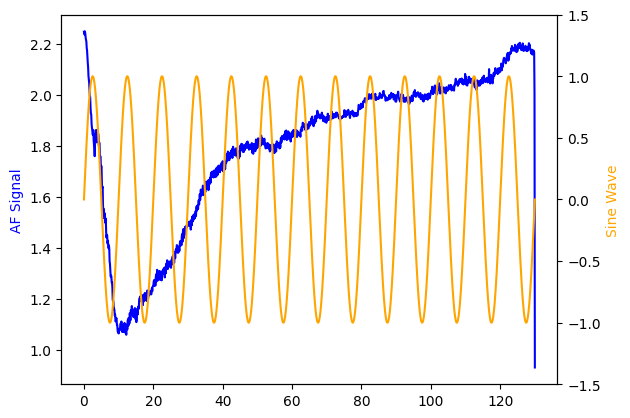

In [56]:
freq_test = 0.1  # This is OK for lowest frequency.
# freq_test = 10 # This will give zero because of aliasing. (Hightest)

# Calculate original frequency
time_index = af.index.values
dt_ori = time_index[1] - time_index[0]
freq_ori = 1 / dt_ori

# Print frequencies
print(f"Original Frequency: {freq_ori} Hz")
print(f"Downsampled Frequency: {freq_test} Hz")

# Create a sine wave for comparison
sine = np.sin(2 * np.pi * freq_test * time_index)

# Plot AF signal and a sine wave for comparison
fig, ax1 = plt.subplots()
ax1.plot(time_index, af.values, label="AF Signal", color="blue")
ax1.set_ylabel("AF Signal", color="blue")
ax2 = ax1.twinx()
ax2.plot(time_index, sine, label="Sine Wave", color="orange")
ax2.set_ylabel("Sine Wave", color="orange")
ax2.set_ylim(-1.5, 1.5)

## Confirm frequency calculation


In [57]:
# waveletname = "morl"
waveletname = "cmor1.5-1.0"

# Define frequencies to test
frequencies = np.array([10, 1, 0.1]) / freq_ori  # normalize

# Calculate scales from frequencies
scale = pywt.frequency2scale(waveletname, frequencies)
print(scale)

# Calculate frequencies from scales
freqs = pywt.scale2frequency(waveletname, [1, 2, 10, 50, 100]) / dt_ori
print(freqs)

[  1.  10. 100.]
[10.   5.   1.   0.2  0.1]


In summary, the scale between 1 and 100 corresponds to frequencies between 10 Hz and 0.1 Hz.
This seems reasonable given the sampling frequency of 10 Hz and the nature of the signal.


## Wavelet transform


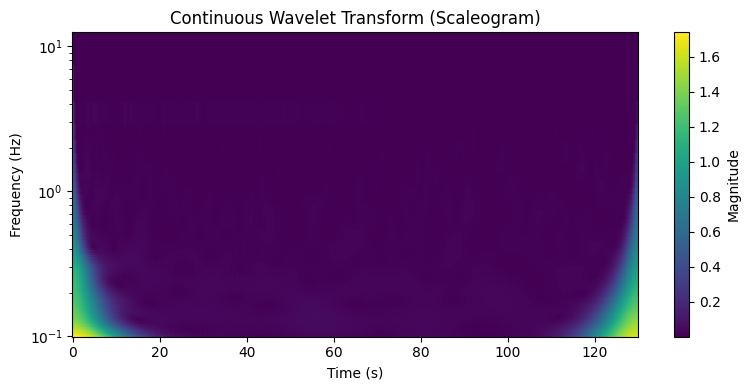

In [58]:
# waveletname = "morl" # Usng Morlet wavelet yield uneven frequency distribution.
waveletname = "cmor1.5-1.0"  # This gives smoother frequency distribution.

n_scales = 100
time = af.index.values
signal = af.values
scales = np.arange(1, n_scales + 1)

# The CWT calculation
dt = time[1] - time[0]
[coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)

fig, axs = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
pcm = axs.pcolormesh(time, frequencies, np.abs(coefficients))
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Frequency (Hz)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs, label="Magnitude")
fig.tight_layout()
# plot_wavelet(
#     time, signal, scales, waveletname=waveletname, xlabel="Time", ylabel="Period"
# )